In [1]:
import numpy as np
from scipy import sparse
from scipy import linalg as la
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["text.usetex"] = True

# ROM Operator Inference Tutorial

The `rom_operator_inference` package constructs reduced-order models (ROM) for large dynamical systems.
Such systems often arise from the numerical solution of partial differentials equations (PDE).
In this tutorial, we give an example of solving a \*very\* simple heat equation with a ROM learned from data via operator inference.

## Problem Statement and Numerical Setting

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $\omega$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$.
We consider the one-dimensional heat equation with homogeneous Dirichlet boundary conditions,
$$
\begin{align}
    \frac{\partial}{\partial t} x(\omega,t) - \frac{\partial^2}{\partial\omega^2}x(\omega,t) &= 0
    & \omega &\in\Omega,\quad t\in(0,T],
    \\
    x(0,t) = x(L,t) &= 0
    & t &\in[0,T],
    \\
    x(\omega,0) &= \omega(1 - \omega),
    & \omega &\in \Omega.
\end{align}
$$

This is a model for a one-dimensional rod that conducts heat: the temperature at the ends of the rod are fixed at $0$ and heat is allowed to flow out of the rod through the ends.
This is the canonical model of diffusion.

To solve the problem numerically, let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$

Since the boundary conditions prescribe $x(\omega_0,t) = x(\omega_{n+1},t) = 0$, we wish to compute the state vector

$$
\mathbf{x}(t) = \left[\begin{array}{c} x(\omega_1,t) \\ \vdots \\ x(\omega_n,t)\end{array}\right]\in\mathbb{R}^n
$$

for various $t\in[0,T]$.

Introducing the finite difference approximation

$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$

we obtain the semi-discrete linear system

$$
\boxed{
\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t),
\qquad
\mathbf{x}(0) = \mathbf{x}_0
}\,,
$$

where

$$
\begin{align}
    A &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{x}_0 &= \left[\begin{array}{c}
    \omega_1 (1 - \omega_1) \\ \omega_2 (1 - \omega_2) \\ \vdots \\ \omega_{n-1} (1 - \omega_{n-1}) \\ \omega_n (1 - \omega_n)
    \end{array}\right] \in\mathbb{R}^{n}.
\end{align}
$$

The boxed equation is the _full-order model_ (FOM).
Our goal is to construct a reduced-order model (ROM) that approximates the FOM.

### Snapshot Data Generation

For simplicity, let $L = T = 1$.
We begin by simulating the full-order system described above with a maximal time step size $\delta t = 10^{-3}$, resulting in $k = 10^3+1$ time steps (1000 steps past the initial condition).
The result is the snapshot matrix $X\in\mathbb{R}^{n\times k}$, where the $j$th column is the solution trajectory at time $t_j$.
We also compute the derivative at each snapshot, obtaining $\dot{X}\in\mathbb{R}^{n\times k}$.

In [3]:
# Construct the spatial domain.
W = 1                           # Spatial domain length.
n = 127                         # Spatial grid size.
w_all = np.linspace(0, W, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid (where x is unknown).
dw = w[1] - w[0]                # Spatial resolution.
dw2inv = 1 / dw**2

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*1000+1                    # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0078125
Temporal step size dt = 0.001


In [4]:
# Construct the state matrix A.
diags = np.array([1, -2, 1]) * dw2inv
A = sparse.diags(diags, [-1,0,1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
f = lambda t,x: A @ x
x0 = w * (1 - w)

print(f"shape of A:\t{A.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A:	(127, 127)
shape of x0:	(127,)


In [5]:
# Compute snapshots by solving the equation with SciPy.
X = solve_ivp(f, [0,T], x0, t_eval=t, method="BDF").y

# Also compute velocities (dx/dt) at each snapshot.
Xdot = A @ X

print(f"shape of X:\t{X.shape}")
print(f"shape of Xdot:\t{Xdot.shape}")

shape of X:	(127, 1001)
shape of Xdot:	(127, 1001)


Finally, we visualize the snapshots to get a sense of how the solution looks qualitatively.

In [6]:
def plot_heat_data(Z, title):
    fig, ax = plt.subplots(1, 1, figsize=(12,4))

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 20, 80, 160, 320, 640]
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])
        ax.plot(w_all, x_all, color=next(color), label=rf"$x(\omega,t_{{{j}}})$")
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$x(\omega,t)$")
    ax.legend(loc="upper left")
    fig.suptitle(title)

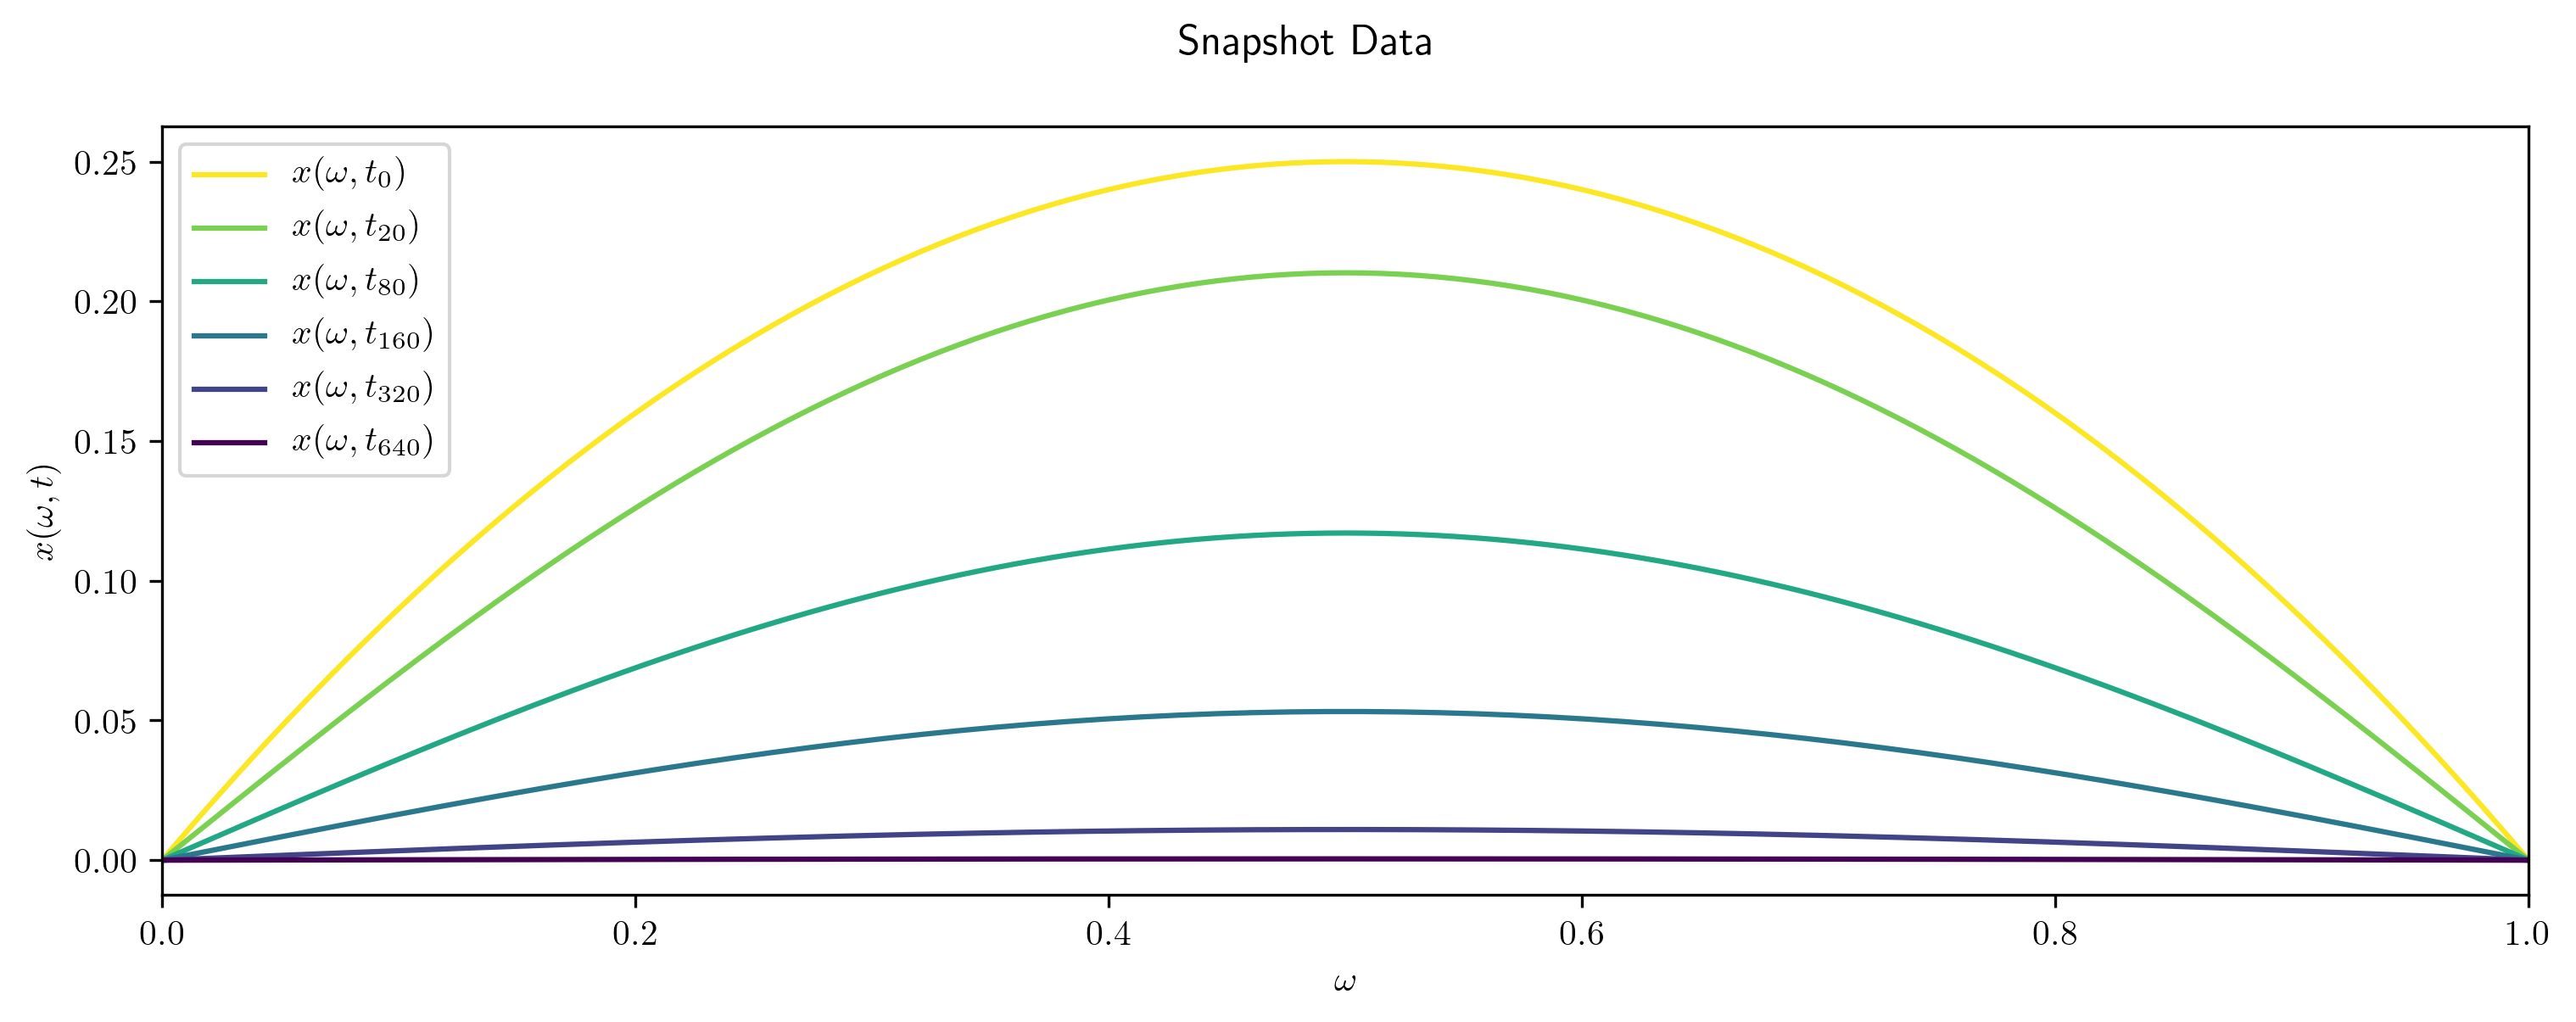

In [7]:
plot_heat_data(X, "Snapshot Data")

Initially there is more heat toward the center of the rod, which then diffuses out of the ends of the rod.

### Summary

At this point, we have gathered some training data by simulating the FOM.
We also have an initial condition and space and time domains.

| Name | Symbol | Code Variable |
| :--- | :----: | :------------ |
| State snapshots | $X$ | `X` |
| Velocity snapshots | $\dot{X}$ | `Xdot` |
| Initial state | $\mathbf{x}_0$ | `x0` |
| | |
| Spatial variable | $\Omega$ | `w` |
| Time domain | $[0,T]$ | `t` |

## Using The Package to Solve the Problem

Since the FOM problem has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$
but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$.

We have several tasks to consider:
1. Choosing the reduced-model dimension,
2. Constructing a low-dimensional subspace,
3. Constructing the ROM via operator inference,
4. Simulating the ROM, and
5. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

In [8]:
import rom_operator_inference as roi

Vr = roi.pre.pod_basis(X, r=2)                      # Construct the reduced basis.
model = roi.InferredContinuousROM(modelform="A")    # Define the model structure.
model.fit(X, Xdot, Vr)                              # Construct the ROM with operator inference.
X_ROM = model.predict(x0, t)                        # Simulate the ROM.
roi.post.frobenius_error(X, X_ROM)[1]               # Calculate the relative error of the ROM simulation.

0.0009116078625495159

### Choosing the Reduced-model Dimension

There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [9]:
roi.pre.significant_svdvals?

Signature: roi.pre.significant_svdvals(X, eps, plot=False)
Docstring:
Count the number of singular values of X that are greater than eps.

Parameters
----------
X : (n,k) ndarray
    A matrix of k snapshots. Each column is a single snapshot.

eps : float or list(floats)
    Cutoff value(s) for the singular values of X.

plot : bool
    If True, plot the singular values and the cutoff value(s) against the
    singular value index.

Returns
-------
ranks : int or list(int)
    The number of singular values greater than the cutoff value(s).
File:      ~/Desktop/Research/Operator-Inference-Python/rom_operator_inference/pre.py
Type:      function


6

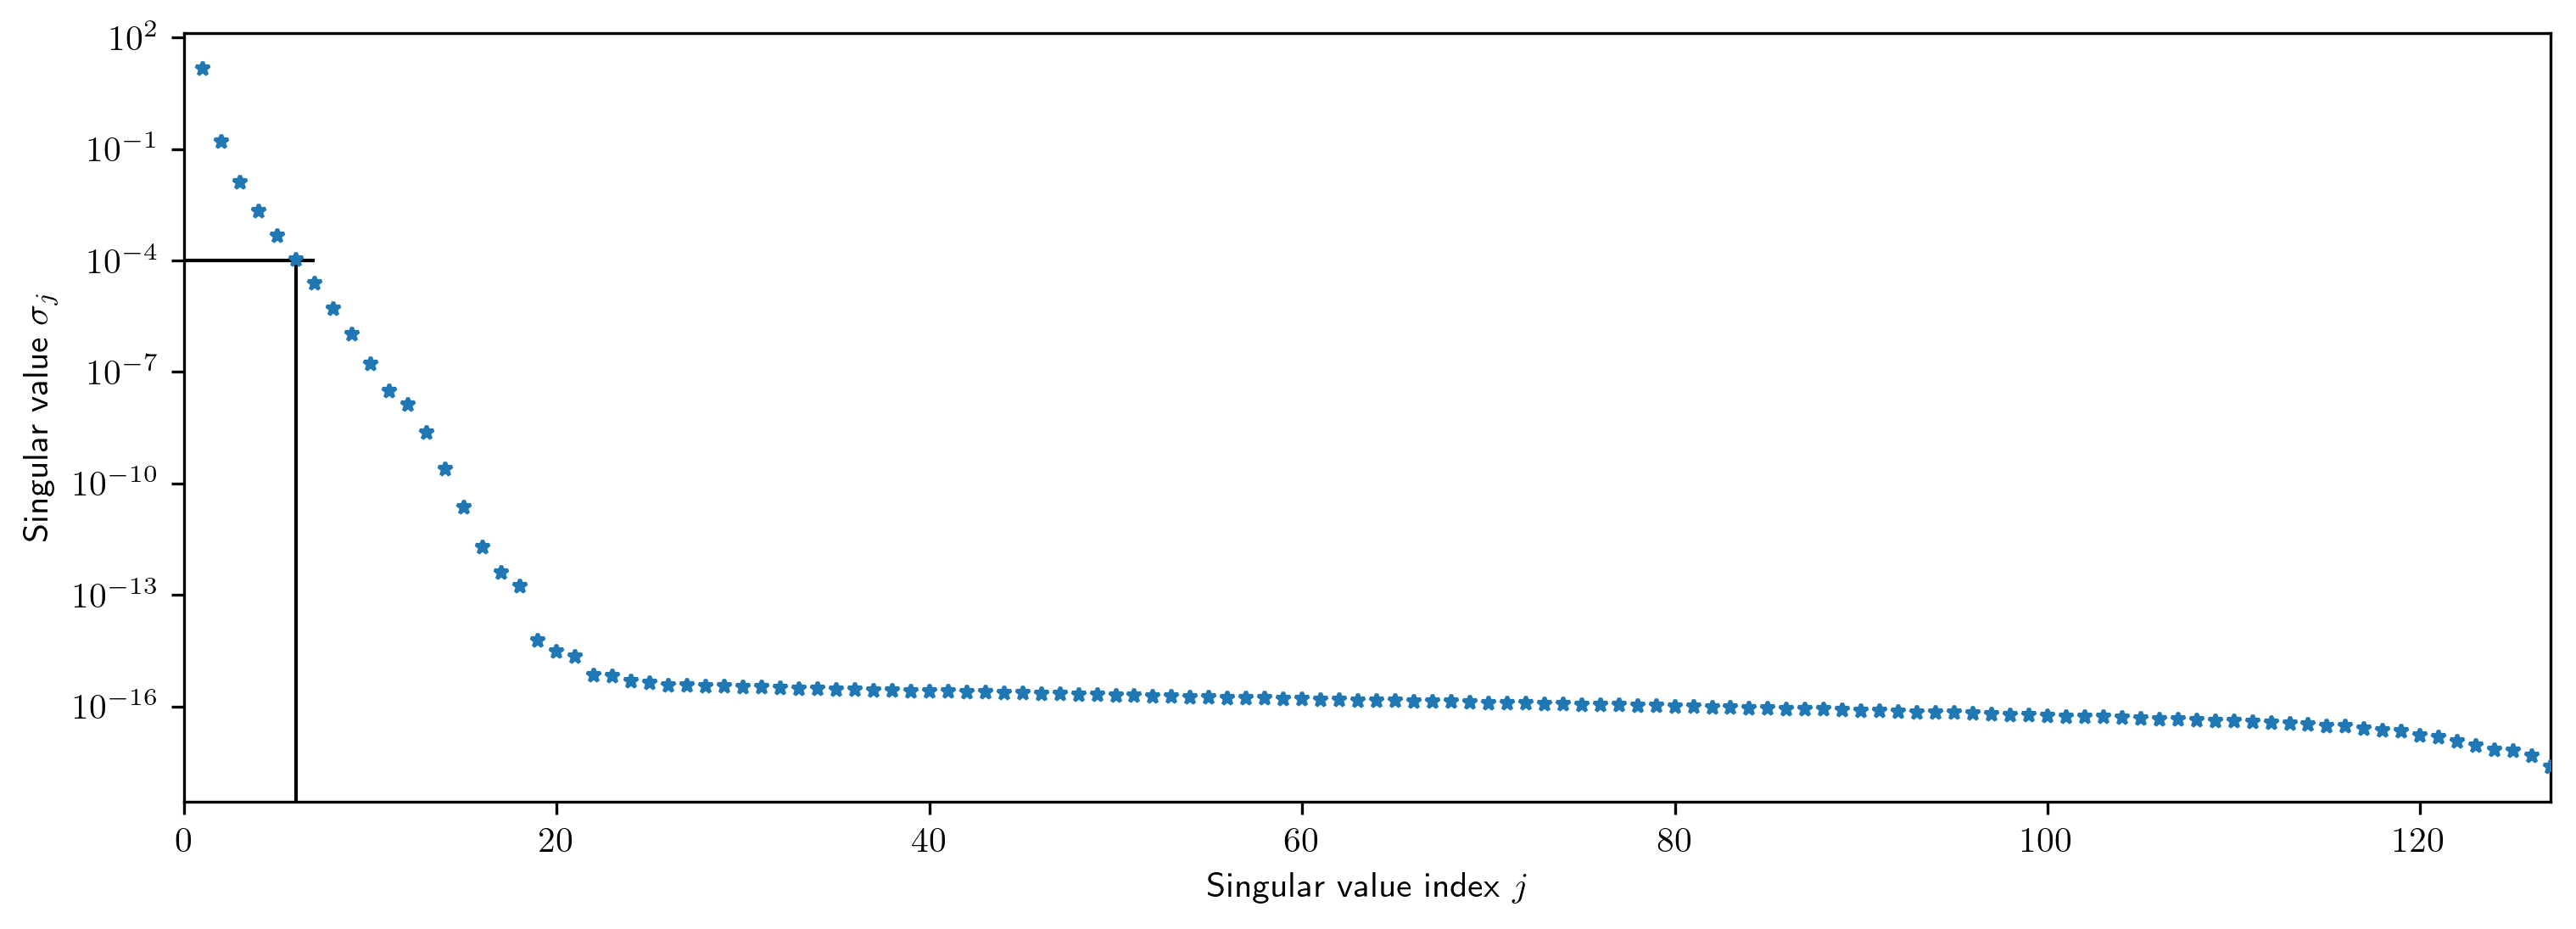

In [10]:
roi.pre.significant_svdvals(X, 1e-4, plot=True)

We can also look at the relative contribution magnitudes of the singular values.

In [11]:
roi.pre.energy_capture?

Signature: roi.pre.energy_capture(X, thresh, plot=False)
Docstring:
Compute the number of singular values of X needed to surpass a given
energy threshold. The energy of j singular values is defined by

    energy_j = sum(singular_values[:j]) / sum(singular_values).

Parameters
----------
X : (n,k) ndarray
    A matrix of k snapshots. Each column is a single snapshot.

thresh : float or list(floats)
    Energy capture threshold(s).

plot : bool
    If True, plot the singular values and the energy capture against
    the singular value index.

Returns
-------
ranks : int or list(int)
    The number of singular values required to capture more than each
    energy capture threshold.
File:      ~/Desktop/Research/Operator-Inference-Python/rom_operator_inference/pre.py
Type:      function


r = 2


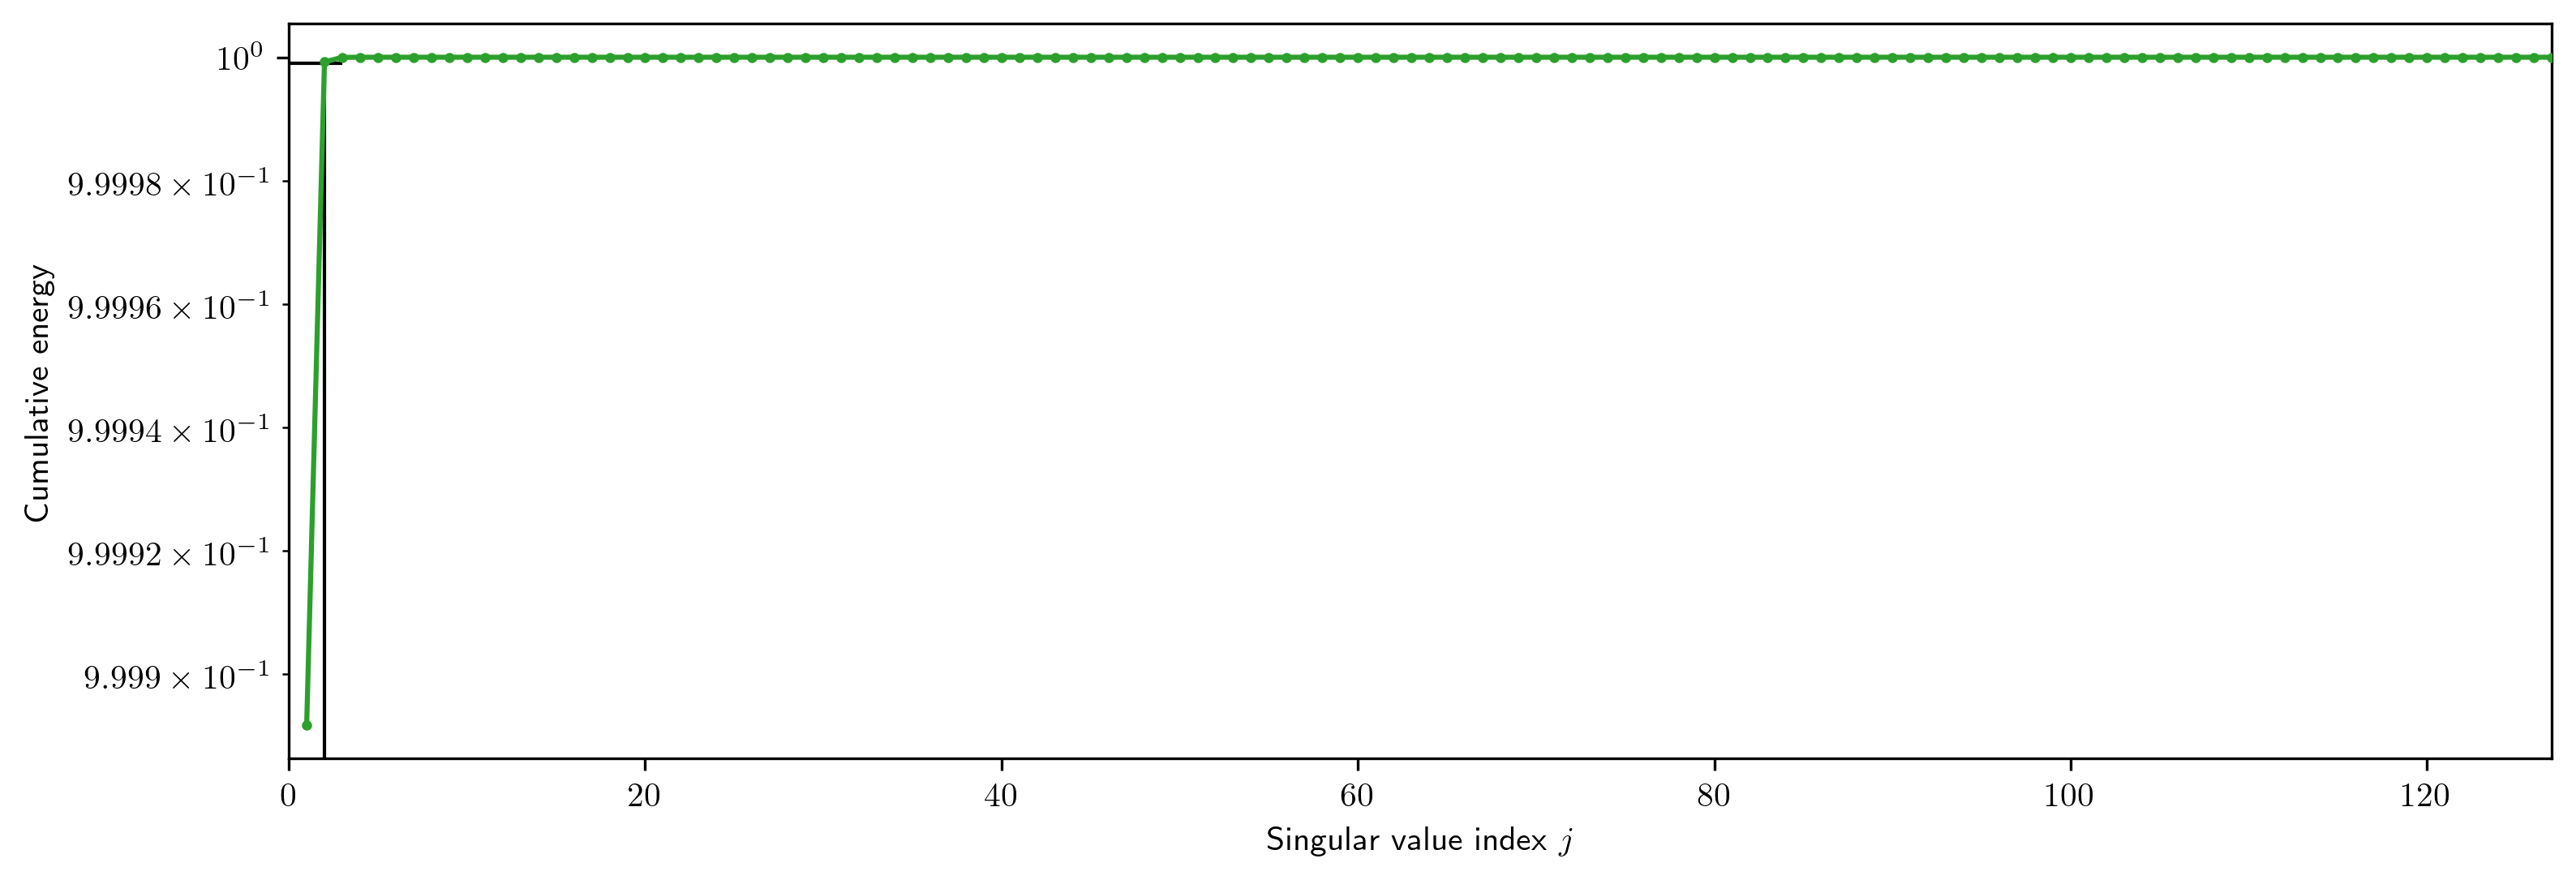

In [12]:
r = roi.pre.energy_capture(X, .999999, plot=True)
print(f"r = {r}")

This indicates that we can capture 99.9999% of the behavior of the FOM with only 2 modes.
This is a very small choice of $r$, but it is also a very simple problem, so for now we select $r = 2$.

### Constructing a Low-dimensional Subspace

Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [13]:
roi.pre.pod_basis?

Signature: roi.pre.pod_basis(X, r, mode='simple', **options)
Docstring:
Compute the POD basis of rank r corresponding to the data in X.
This function does NOT shift or scale the data before computing the basis.

Parameters
----------
X : (n,k) ndarray
    A matrix of k snapshots. Each column is a single snapshot.

r : int
    The number of POD basis vectors to compute.

mode : str
    The strategy to use for computing the truncated SVD of X. Options:
    * "simple" (default): Use scipy.linalg.svd() to compute the entire SVD
        of X, then truncate it to get the first r left singular vectors of
        X. May be inefficient for very large matrices.
    * "arpack": Use scipy.sparse.linalg.svds() to compute only the first r
        left singular vectors of X. This uses ARPACK for the eigensolver.
    * "randomized": Compute an approximate SVD with a randomized approach
        using sklearn.utils.extmath.randomized_svd(). This gives faster
        results at the cost of some accuracy.

In [14]:
r=2
Vr = roi.pre.pod_basis(X, r, mode="simple")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (127, 2)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

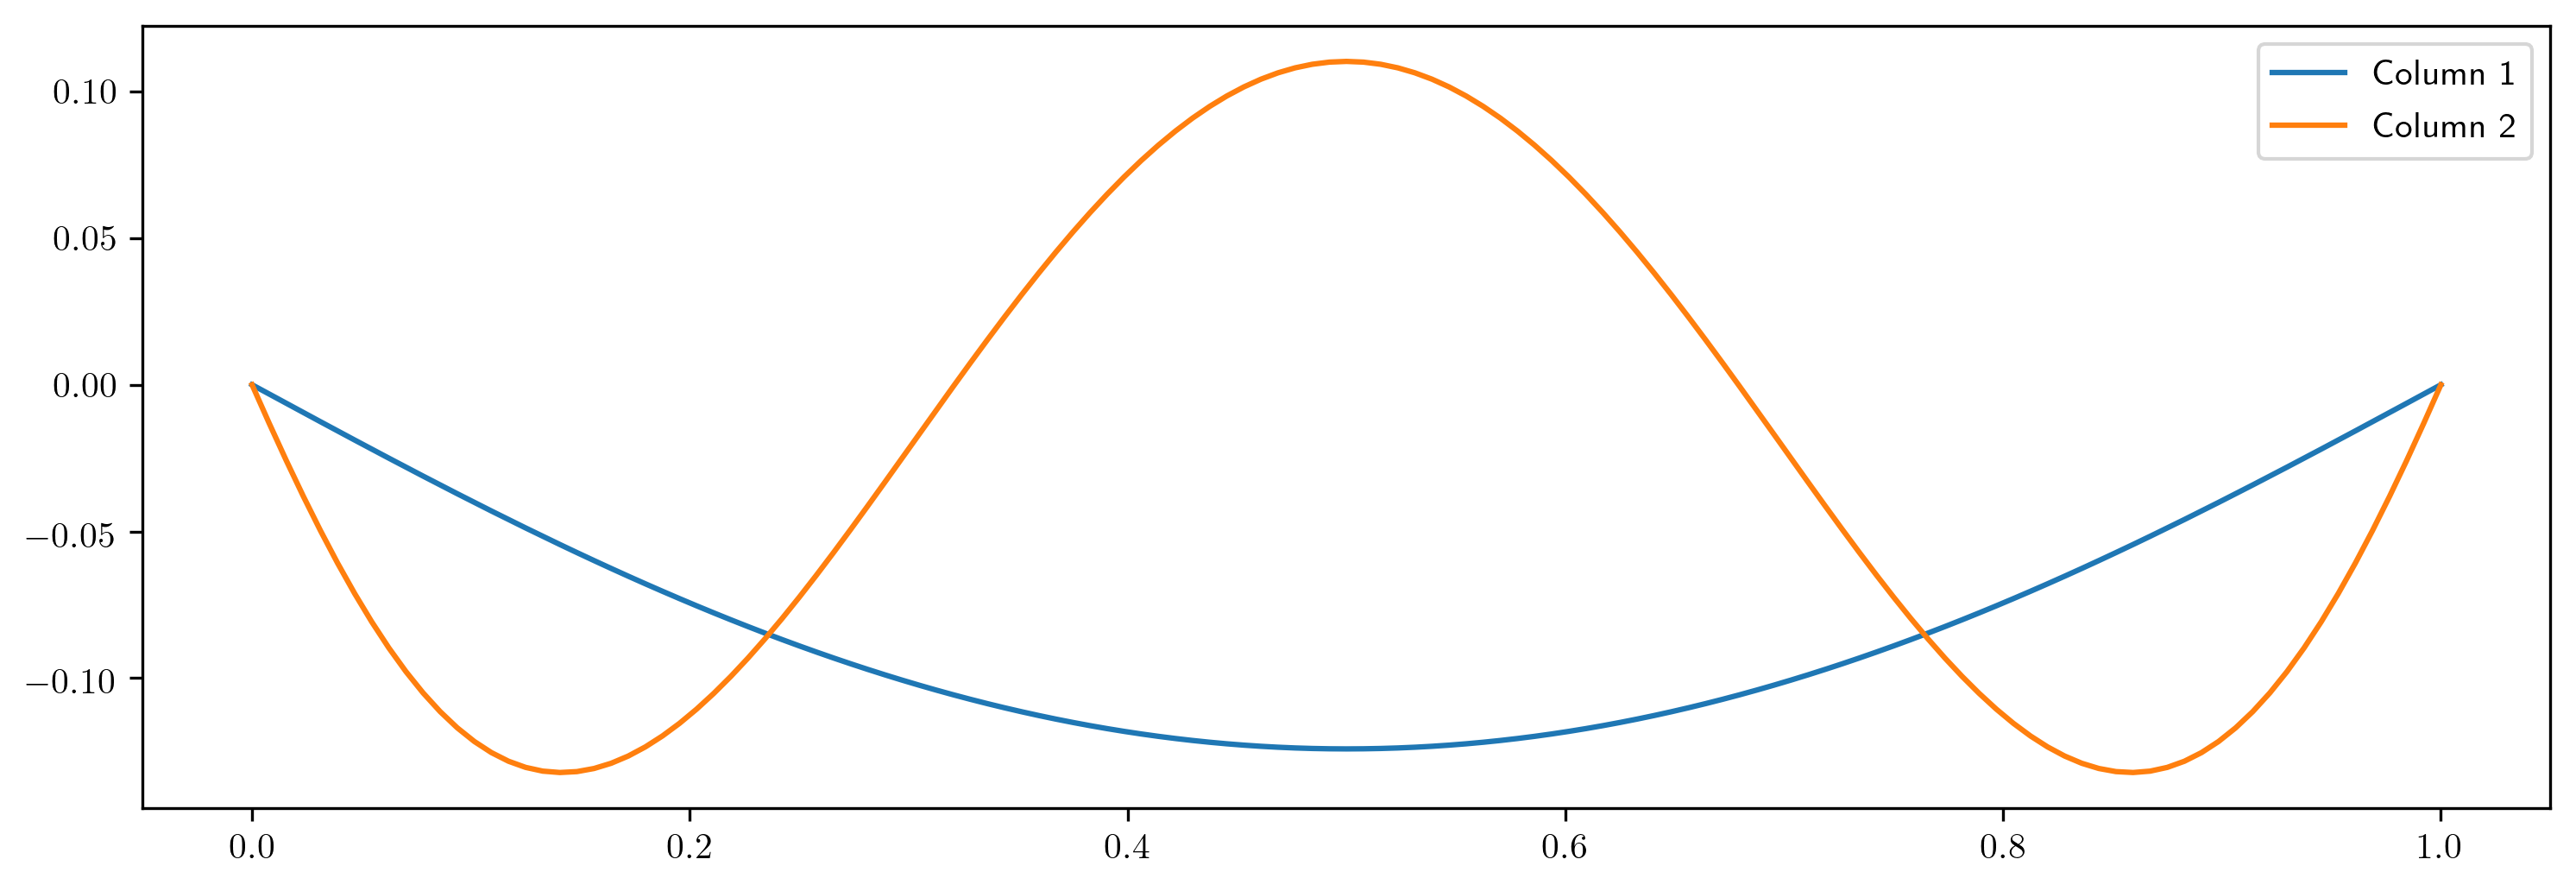

In [15]:
for j in range(Vr.shape[1]):
    plt.plot(w_all, np.concatenate(([0], Vr[:,j], [0])), label=f"Column {j+1}")
plt.legend()
plt.show()

### Constructing the ROM via Operator Inference

We now have training data _and_ a linear basis for a low-dimensional subspace.

| Name | Symbol | Code Variable |
| :--- | :----: | :------------ |
| State snapshots | $X$ | `X` |
| Velocity snapshots | $\dot{X}$ | `Xdot` |
| POD basis | $V_{r}$ | `Vr` |
| Initial state | $\mathbf{x}_0$ | `x0` |
| | |
| Spatial variable | $\Omega$ | `w` |
| Time domain | $[0,T]$ | `t` |

Next, we initialize a `rom_operator_inference` "ROM" class and fit it to the data.
Since the problem is continuous (time-dependent) and there are no external parameters, we use the `InferredContinuousROM` class.
The constructor takes a single parameter, `modelform`, that specifies the structure of the desired model.

| Character | Name | Reduced-order Model Term |
| :-------- | :--- | :------- |
| `c` | Constant |  $\hat{\mathbf{c}}$ |
| `A` | Linear |  $\hat{A}\hat{\mathbf{x}}(t)$ |
| `H` | Quadratic |  $\hat{H}\left(\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\right)(t)$ |
| `B` | Input |  $\hat{B}\mathbf{u}(t)$ |

Since we seek a ROM of the form $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t)$, we want `modelform="A"`.
If there were a constant term, $\frac{d}{dt}\hat{\mathbf{x}}(t) = \mathbf{c} + \hat{A}\hat{\mathbf{x}}(t)$, we would use `modelform="cA"`, and so on.

In [16]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{X}^\mathsf{T}\hat{A}^\mathsf{T} - \dot{\hat{X}}^\mathsf{T}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [17]:
model.fit?

Signature: model.fit(X, Xdot, Vr, U=None, P=0)
Docstring:
Solve for the reduced model operators via regularized least squares.

Parameters
----------
X : (n,k) ndarray
    Column-wise snapshot training data (each column is a snapshot).

Xdot : (n,k) ndarray
    Column-wise velocity training data.

Vr : (n,r) ndarray
    The basis for the linear reduced space (e.g., POD basis matrix).

U : (m,k) or (k,) ndarray or None
    Column-wise inputs corresponding to the snapshots. If m=1 (scalar
    input), then U may be a one-dimensional array. Required if 'B' is
    in `modelform`; must be None if 'B' is not in `modelform`.

P : (d,d) ndarray or float
    Tikhonov regularization matrix. If nonzero, the least-squares
    problem problem takes the form min_{x} ||Ax - b||^2 + ||Px||^2.
    If a nonzero number is provided, the regularization matrix is
    P * I (a scaled identity matrix). Here d is the dimension of the
    data matrix for the least-squares problem, e.g., d = r + m for a
    linea

In [18]:
model.fit(X, Xdot, Vr)

After fitting the model, we can directly examine the inferred operators of the model.

In [19]:
model.A_

array([[ -9.87390272,  -0.62666937],
       [ -0.62666937, -92.61560522]])

In this case, because this is such a simple problem, operator inference essentially recovers the exact same operator $\hat{A}$ as intrusive projection, i.e., $\hat{A} = V_r^\mathsf{T} A V_r$:

In [20]:
Vr.T @ A @ Vr

array([[ -9.87390272,  -0.62666937],
       [ -0.62666937, -92.61560522]])

In [21]:
np.allclose(model.A_, Vr.T @ A @ Vr)

True

### Simulating the Reduced Model

Once the model is fit, we simulate it with the `predict()` method.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [22]:
model.predict?

Signature: model.predict(x0, t, u=None, **options)
Docstring:
Simulate the learned ROM with scipy.integrate.solve_ivp().

Parameters
----------
x0 : (n,) ndarray
    The initial (high-dimensional) state vector to begin a simulation.

t : (nt,) ndarray
    The time domain over which to integrate the reduced-order system.

u : callable or (m,nt) ndarray
    The input as a function of time (preferred) or the input at the
    times `t`. If given as an array, u(t) is approximated by a cubic
    spline interpolating the known data points.

options
    Arguments for solver.integrate.solve_ivp(), such as the following:
    method : str
        The ODE solver for the reduced-order system.
        * 'RK45' (default): Explicit Runge-Kutta method of order 5(4).
        * 'RK23': Explicit Runge-Kutta method of order 3(2).
        * 'Radau': Implicit Runge-Kutta method of the Radau IIA family
            of order 5.
        * 'BDF': Implicit multi-step variable-order (1 to 5) method
            base

In [23]:
X_ROM = model.predict(x0, t, method="BDF")
X_ROM.shape

(127, 1001)

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output.
It should look similar to the plot of the snapshot data.

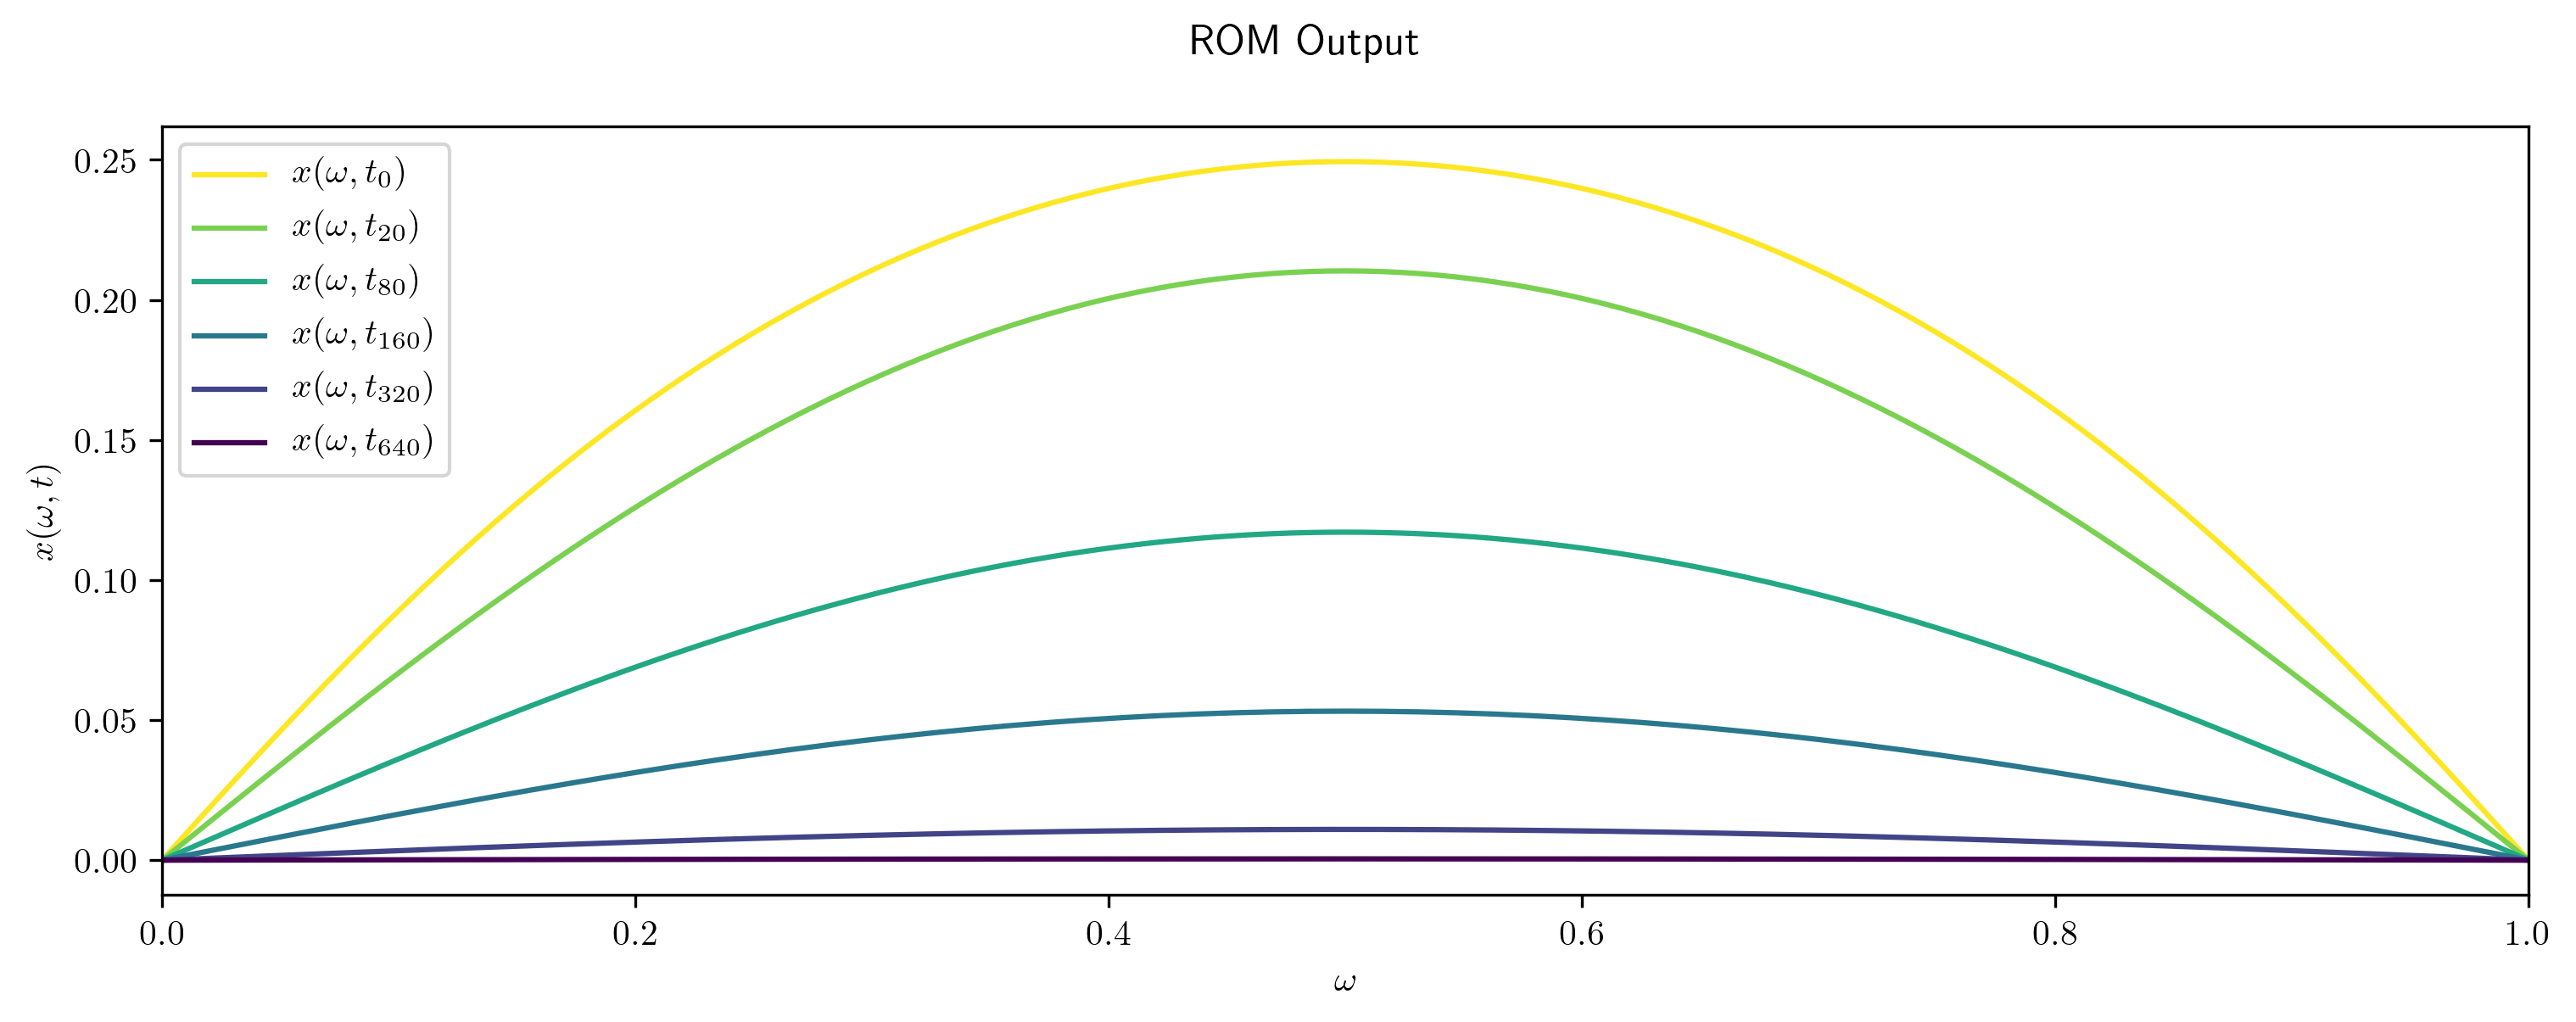

In [24]:
plot_heat_data(X_ROM, "ROM Output")

For more detail, we evaluate the $\ell^p$ error of the ROM output in time, comparing it to the snapshot set.

In [25]:
roi.post.lp_error?

Signature: roi.post.lp_error(X, Y, p=2, normalize=False)
Docstring:
Compute the absolute and relative lp-norm errors between two snapshot
sets X and Y where Y is an approximation to X,

    Abs_Err_j = ||X_j - Y_j||_p,
    Rel_Err_j = ||X_j - Y_j||_p / ||X_j||_p = Abs_Err_j / ||X_j||_p.

Parameters
----------
X : (n,k) or (n,) ndarray
    The "true" data. Each column is one snapshot, i.e., X[:,j] is the data
    at some time t[j]. If one-dimensional, all of X is a single snapshot.

Y : (n,k) or (n,) ndarray
    An approximation to X, i.e., Y[:,j] approximates X[:,j] and corresponds
    to some time t[j]. If one-dimensional, all of Y is a single snapshot
    approximation.

p : float
    The order of the lp norm (default p=2 is the Euclidean norm). Used as
    the `ord` argument for scipy.linalg.norm(); see options at
    docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.norm.html.

normalize : bool
    If true, compute the normalized absolute error instead of the relative
    e

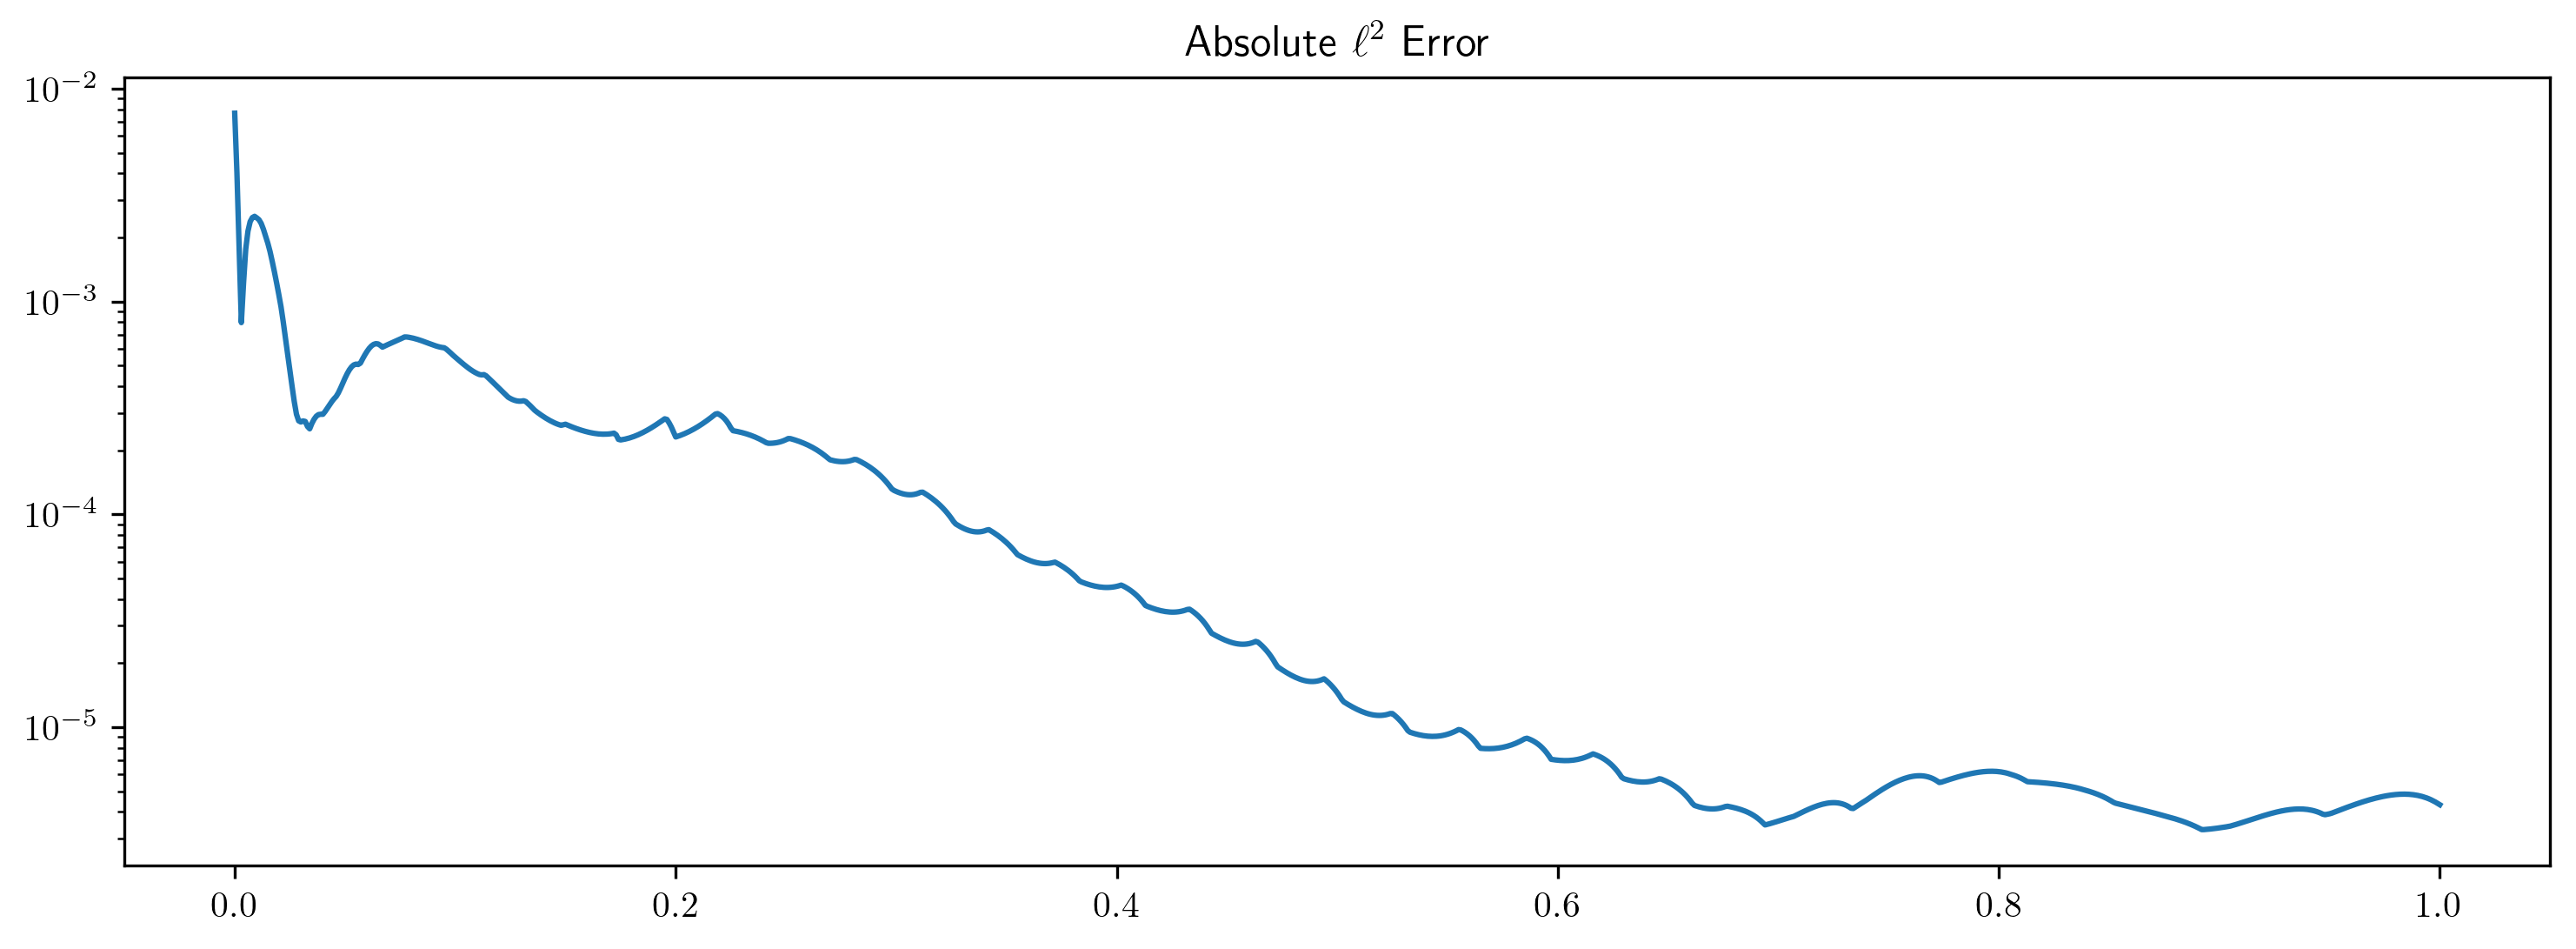

In [26]:
plt.semilogy(t, roi.post.lp_error(X, X_ROM)[0])
plt.title(r"Absolute $\ell^2$ Error")
plt.show()

We can also get a scalar error measurement by calculating the relative Frobenius norm error.

In [27]:
roi.post.frobenius_error?

Signature: roi.post.frobenius_error(X, Y)
Docstring:
Compute the absolute and relative Frobenius-norm errors between two
snapshot sets X and Y where Y is an approximation to X,

    Abs_Err = ||X - Y||_F,
    Rel_Err = ||X - Y||_F / ||X||_F = Abs_Err / ||X||_F.

Parameters
----------
X : (n,k)
    The "true" data. Each column is one snapshot, i.e., X[:,j] is the data
    at some time t[j].

Y : (n,k)
    An approximation to X, i.e., Y[:,j] approximates X[:,j] and corresponds
    to some time t[j].

Returns
-------
abs_err : float
    The absolute error ||X - Y||_F.

rel_err : float
    The relative error ||X - Y||_F / ||X||_F.
File:      ~/Desktop/Research/Operator-Inference-Python/rom_operator_inference/post.py
Type:      function


In [28]:
roi.post.frobenius_error(X, X_ROM)[1]  # RELATIVE Frobenius error.

0.0009231209515532893

In other words, the ROM simulation is within 0.1% of the snapshot data.